# Assignment 6
1. Use yeast dataset from UCI http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data
2. Remove the first column and use the last column as the target
3. Only leave CYT and VAC classes
4. Replace [0.3, 0.5, 0.7] in feature 2 to null
5. Replace [0.26, 0.36, 0.64] in feature 3 to null
6. Split the data

7. Impute the data (or not, it's your call)
8. Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1
9. Build a classifer using sample augmentation techniques to flassify VAC from CYT, i.e. 0 from 1
10. Try different methods and hyper paramters

11. Report perfromance using F-1 score

In [95]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
#Load the dataset into a pandas dataframe
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data'
yeast_data = pd.read_fwf(url,header= None)
# Descriptive statistics of the DataFrame
yeast_data.head()

,0,1,2,3,4,5,6,7,8,9
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [96]:
#we drop the first column as it is not needed for this problem
yeast_data = yeast_data.iloc[: , 1:]
yeast_data.head()

,1,2,3,4,5,6,7,8,9
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [97]:
yeast_data

,1,2,3,4,5,6,7,8,9
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT
...,...,...,...,...,...,...,...,...,...
1479,0.81,0.62,0.43,0.17,0.5,0.0,0.53,0.22,ME2
1480,0.47,0.43,0.61,0.40,0.5,0.0,0.48,0.47,NUC
1481,0.67,0.57,0.36,0.19,0.5,0.0,0.56,0.22,ME2
1482,0.43,0.40,0.60,0.16,0.5,0.0,0.53,0.39,NUC


In [98]:
yeast_data[9].value_counts(dropna = False)


CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: 9, dtype: int64

In [99]:
yeast_data = yeast_data.loc[(yeast_data[9] == "CYT") | (yeast_data[9] == "VAC")]
yeast_data

,1,2,3,4,5,6,7,8,9
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
12,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25,CYT
15,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22,CYT
16,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40,CYT
...,...,...,...,...,...,...,...,...,...
1475,0.71,0.50,0.50,0.18,0.5,0.0,0.46,0.22,CYT
1476,0.61,0.48,0.54,0.25,0.5,0.0,0.50,0.22,CYT
1477,0.38,0.32,0.64,0.41,0.5,0.0,0.44,0.11,CYT
1478,0.38,0.40,0.66,0.35,0.5,0.0,0.43,0.11,CYT


In [100]:
yeast_data[2].replace({0.3:np.NaN, 0.5:np.NaN, 0.7:np.NaN}, inplace=True)
yeast_data[3].replace({0.26:np.NaN, 0.36:np.NaN, 0.64:np.NaN}, inplace=True)
yeast_data.isna().sum()


1     0
2    26
3     5
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64

In [101]:
# all columns but the last
X = yeast_data.iloc[: , :-1]
# the last column of the df 
y = yeast_data.iloc[:,-1:]


In [102]:
y.replace({("CYT"): 1}, inplace=True)
y.replace({("VAC"): 0}, inplace=True)


In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [109]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)
y_train_array = y_train.to_numpy().ravel()
y_test_array = y_test.to_numpy().ravel()


In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import StratifiedKFold

#Benchmark model with no outlier detection method
pipe = Pipeline([('classifier', SVC())])

param_grid = [
     {'classifier': [SGDClassifier()],
      'classifier__average': [True, False],
      'classifier__l1_ratio': [0.001, 0.01, 0.1, 1],
      'classifier__alpha': [0.001, 0.01, 0.1, 1]},
    
     {'classifier': [SVC()],
      'classifier__gamma':[0.001, 0.01, 0.1, 1],
      'classifier__C': [100,1000,1250,1500]},
    
     {'classifier': [LogisticRegression()], 
      'classifier__C': [0.001, 0.01, 0.1, 1]}]

grid_search = GridSearchCV(pipe, param_grid, cv = StratifiedKFold(), scoring='f1')
start = time()
grid_search.fit(X_train_imp, y_train_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))


Model training took 1.10 seconds
Best cross-validation score: 0.97
Test set score: 0.98
Best parameters: {'classifier': SVC(C=1000, gamma=1), 'classifier__C': 1000, 'classifier__gamma': 1}



In [116]:
from sklearn.cluster import DBSCAN
from numpy import random, where

outliers = DBSCAN(eps = 0.25, min_samples = 20)
pred = outliers.fit_predict(X_train_imp)


In [117]:
anom_index = where(pred == 0)
X_train_out = X_train_imp[anom_index]
y_train_out= y_train_array[anom_index]



In [119]:
start = time()
grid_search.fit(X_train_out, y_train_out)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))

Model training took 1.08 seconds
Best cross-validation score: 0.97
Test set score: 0.97
Best parameters: {'classifier': SVC(C=1000, gamma=1), 'classifier__C': 1000, 'classifier__gamma': 1}



In [123]:
from sklearn.covariance import EllipticEnvelope



outliers = EllipticEnvelope(contamination=.05)
pred = outliers.fit_predict(X_train_imp)
anom_index = where(pred == 1)
X_train_out = X_train_imp[anom_index]
y_train_out= y_train_array[anom_index]
start = time()
grid_search.fit(X_train_out, y_train_out)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))


Model training took 1.06 seconds
Best cross-validation score: 0.97
Test set score: 0.97
Best parameters: {'classifier': SVC(C=1000, gamma=1), 'classifier__C': 1000, 'classifier__gamma': 1}



In [130]:
color = ['blue','orange']

target_count = y_train.value_counts()

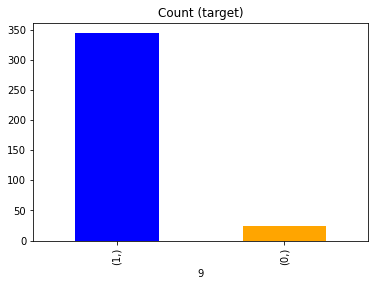

In [131]:
target_count.plot(kind='bar', title='Count (target)', color = color);


In [133]:
! pip install imblearn --user

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train_imp, y_train)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')


195 new random picked points


Random over-sampling:
9  
1.0    344
0.0    344
dtype: int64


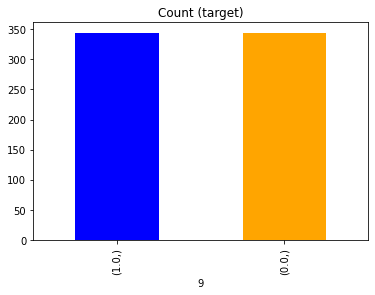

In [134]:
# Class count
count_class_0, count_class_1 = y_ros.value_counts()

# Divide by class
df_class_0 = y_ros[y_ros == 0]
df_class_1 = y_ros[y_ros == 1]

df_test_over = pd.concat([df_class_0, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.value_counts())

df_test_over.value_counts().plot(kind='bar', title='Count (target)',color = color);


In [137]:
# Convert to numpy
y_ros_array = y_ros.to_numpy().ravel()

start = time()
grid_search.fit(X_ros, y_ros_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))

Model training took 1.99 seconds
Best cross-validation score: 0.84
Test set score: 0.91
Best parameters: {'classifier': SVC(C=1500, gamma=1), 'classifier__C': 1500, 'classifier__gamma': 1}



In [ ]:
# Convert to numpy
y_ros_array = y_ros.to_numpy().ravel()

start = time()
grid_search.fit(X_ros, y_ros_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))